In [1]:
pip install tensorflow

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


## Using Tenssorflow as backend

## Dataset used: NIH Covid-19_Radiography_dataset
#### COVID-19: 3616
#### Normal: 10,192
#### Lung Opacity(Non-COVID lung infection): 1345
#### Viral Pneumonia: 1345
#### Size of Image: 299 x 299 x 1

In [2]:
# Matthew Liu COVID-19 X-Ray Classification

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers  import Dropout
from tensorflow.keras.layers  import Dense
from tensorflow.keras.layers  import Flatten
from tensorflow.keras.layers  import Softmax
from tensorflow.keras.layers  import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import cv2
from nn_transfer import transfer, util

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## Data preprocessing

In [ ]:
data =[]
labels = []
INIT_LR = 1e-4
EPOCHS = 300
BS = 32

In [3]:
CATERGORIES = ['COVID','Non-COVID']
sample_num = 0
for img in os.listdir('COVID'):
    if sample_num <= -1:
        sample_num += 1
        continue
    if sample_num == 3000:
        break;
    img_path = 'COVID' + '/' + img
    try:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128,128))
    except(Exception):
        continue
    data.append(image)
    labels.append(CATERGORIES[0])
    sample_num += 1

In [4]:
DIRECTORY = ['Normal','Lung_Opacity','Viral Pneumonia']
for num in range(0,3):
    sample_num = 0
    for img in os.listdir(DIRECTORY[num]):
        if sample_num <= -1:
            sample_num += 1
            continue
        if sample_num == 2000:
            break; 
        img_path = DIRECTORY[num] + '/' + img
        try:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128,128))
        except(Exception):
            continue
        data.append(image)
        labels.append(CATERGORIES[1])
        sample_num += 1

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data) / 255
data = data.reshape(-1,128,128,1)
labels = np.array(labels)

In [6]:
(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.2,random_state=32,stratify=labels)
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                         horizontal_flip=True,fill_mode='nearest')

In [19]:
img = aug.flow(trainX, batch_size=BS)

## Example of Augmented Data for training

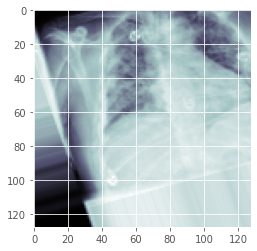

In [20]:
plt.imshow(img[0][10],cmap='bone')

## Examples of Original Data

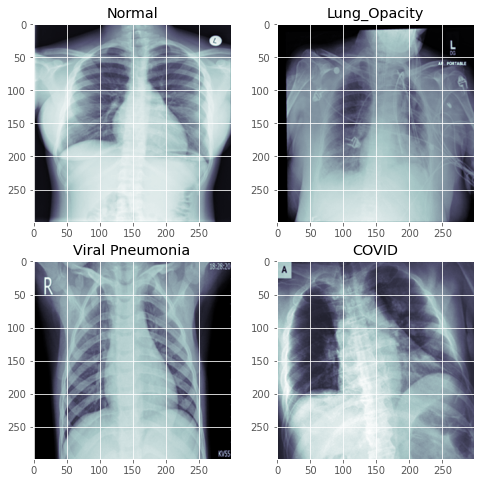

In [26]:
DIRECTORY.append("COVID")
fig, axs = plt.subplots(2,2, figsize=(8,8))
for (dir ,ax) in zip (DIRECTORY, axs.flatten()):
    path = dir + '/' + dir + "-2.png"
    s_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ax.imshow(s_img, cmap='bone')
    ax.set_title(dir)

## Model building
#### A new model architure is employed for building a light-weight model
#### Inputs are modified as 128 x 128 images for a higher computation efficency

In [7]:
# Run on Gpu if possible
with tf.device('/GPU:0'):
    model = models.Sequential()
    model.add(layers.Input(shape=(128,128,1)))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.AvgPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.AvgPool2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.AvgPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.AvgPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.AvgPool2D(pool_size=(3,3)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.summary()

    opt = Adam(learning_rate=INIT_LR,decay=INIT_LR/EPOCHS)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

## Model Training 

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Epoch 1/300
208/208 [==============================] - 176s 841ms/step - loss: 0.6418 - accuracy: 0.6404 - val_loss: 0.6700 - val_accuracy: 0.6405
Epoch 2/300
208/208 [==============================] - 133s 638ms/step - loss: 0.6066 - accuracy: 0.6574 - val_loss: 0.5857 - val_accuracy: 0.6932
Epoch 3/300
208/208 [==============================] - 133s 636ms/step - loss: 0.5509 - accuracy: 0.7031 - val_loss: 0.5314 - val_accuracy: 0.7232
Epoch 4/300
208/208 [==============================] - 136s 651ms/step - loss: 0.5298 - accuracy: 0.7256 - val_loss: 0.5501 - val_accuracy: 0.7070
Epoch 5/300
208/208 [==============================] - 148s 711ms/step - loss: 0.5110 - accuracy: 0.7380 - val_loss: 0.5058 - val_accuracy: 0.7460
Epoch 6/300
208/208 [==============================] - 142s 682ms/step - loss: 0.4948 - accuracy: 0.7510 - val_loss: 0.5099 - val_accuracy: 0.7274
Epoch 7/300
208/208 [==============================] - 140s 667ms/step - loss: 0.4864 - accuracy: 0.7530 - val_loss: 0

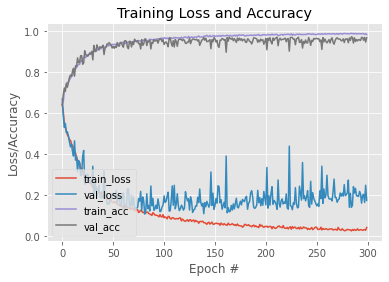

In [8]:
    H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) / BS,
              validation_data=(testX,testY), validation_steps=len(testX) / BS, epochs=EPOCHS)
# Save the Train loss and accuracy plot
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("covid-19_model.png")

### Save Model

In [57]:
model.save("covid_19.model",save_format="h5")

### How the saved plot looks like

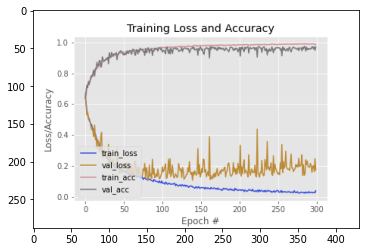

In [5]:
loss_fig = cv2.imread("covid-19_model.png")
plt.imshow(loss_fig)

## Model Evaluation

In [58]:
loss, acc = model.evaluate(testX, testY)

53/53 [==============================] - 6s 105ms/step - loss: 0.1745 - accuracy: 0.9688


In [52]:
classes = ['COVID', 'Non-COVID']
predictions = model.predict_classes(testX)
predictions = predictions.reshape(1, -1)[0]
print(classification_report(testY.argmax(axis=1), predictions, target_names=classes))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

       COVID       0.96      0.96      0.96       600
   Non-COVID       0.98      0.97      0.98      1069

    accuracy                           0.97      1669
   macro avg       0.97      0.97      0.97      1669
weighted avg       0.97      0.97      0.97      1669



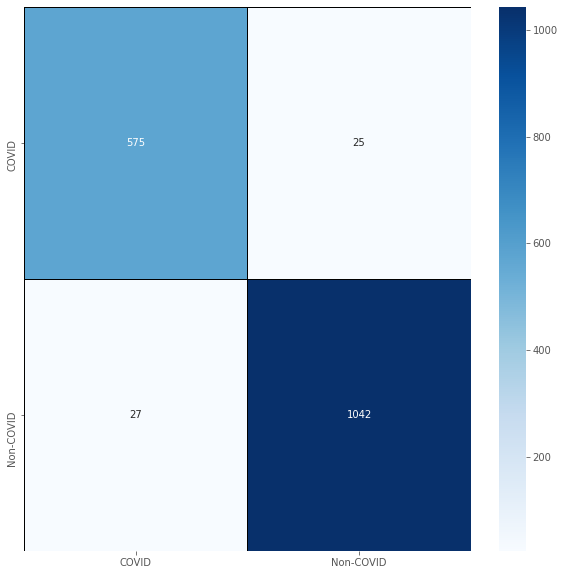

In [56]:
cm = confusion_matrix(testY.argmax(axis=1), predictions)

plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues", linecolor='black',
            linewidth=1, annot=True, fmt='', xticklabels=classes,
            yticklabels=classes)
plt.show()